In [1]:
import pandas as pd
import numpy as np
import time 

import seaborn as sns
import matplotlib.pyplot as plt
import os

import matplotlib.pyplot as pyplot
from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn import svm

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss

from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.cross_validation import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

from IPython.display import display
%matplotlib inline

/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Final Capstone
## Exploring and modelling a tech giant's dataset.

In this notebook, we'll explore and model a dataset from China's largest third-party mobile platform, TalkingData. Understanding that everyday choices and behaviors draw a picture of who we are and what we value, we can use this information to optimize apps and manage marketing resources. The dataset contains information regarding app usage, geolocation and mobile device properties. My objective is to predict user’s demographic characteristics based on the latter information, which in return gives us valuable information that will help millions of developers and brand advertisers around the world pursue data-driven marketing efforts which are relevant to their users and catered to their preferences.


__Sections:__

[Data](#section1)<br>
[Data Processing](#section2)<br>
[Data analysis](#section3)<br>
[Combining Data](#section4)<br>
[Training, testing and evaluation](#section5)<br>
1. [Training and testing with GridSearchCV](#section6)<br>
2. [Training and testing applying PCA](#section7)<br>
3. [Training and testing applying PCA and KMeans Clustering](#section8)<br>
4. [Running Neural Networks models](#section9)<br>

<a id='section1'></a>
## Dataset

The original dataset consisted of 7 files that contained a minum of 930 rows and a maximum of 32473067, the corresponding shapes are the following:

- App events shape: (32473067, 4)
- App labels shape: (459943, 2)
- App events shape: (3252950, 5)
- Gender age train shape: (74645, 4)
- Gender age test shape: (112071, 1)
- Label Categories shape: (930, 3)
- Phone brand device shape: (187245, 3)

Therefore, to agilize the data processing of these files I decided to use the following function to chunk the files to approximately 0,5 % of the original size:

In [2]:
def split(filehandler, delimiter=',', row_limit=4500,
          output_name_template='output_%s.csv', output_path='.', keep_headers=True):
    reader = csv.reader(filehandler, delimiter=delimiter)
    current_piece = 1
    current_out_path = os.path.join(
        output_path,
        output_name_template % current_piece
    )
    current_out_writer = csv.writer(open(current_out_path, 'w'), delimiter=delimiter)
    current_limit = row_limit
    if keep_headers:
        headers = next(reader)
        current_out_writer.writerow(headers)
    for i, row in enumerate(reader):
        if i + 1 > current_limit:
            current_piece += 1
            current_limit = row_limit * current_piece
            current_out_path = os.path.join(
                output_path,
                output_name_template % current_piece
            )
            current_out_writer = csv.writer(open(current_out_path, 'w'), delimiter=delimiter)
            if keep_headers:
                current_out_writer.writerow(headers)
        current_out_writer.writerow(row)

By doing this, and uploading the dataset to a Google Cloud Platform virtual machine of high performance, I was able to reduce the computational time it was taking to process my script on my personal computer.

As we have several dataset to our disposal I created various Pandas dataframes to manipulate and understand the data better. This way at the end of this process we will be able to combine al the datasets to use in our quest for a rightious model.

In [3]:
# Creating Pandas dataframes for each dataset

app_events = pd.read_csv('app_events_smaller.csv')
app_labels = pd.read_csv('app_labels_smaller.csv')
events = pd.read_csv('events_smaller.csv')
gender_age_test = pd.read_csv('gender_age_test_smaller.csv')
gender_age_train = pd.read_csv('gender_age_train_smaller.csv')
label_categories = pd.read_csv('label_categories.csv')
phone_brand_device_model = pd.read_csv('phone_brand_device_model.csv')

In [4]:
print('Training dataset header:')
display(gender_age_train.head())
print('Dataset shape:', gender_age_train.shape)
print('')
print('Events dataset header:')
display(events.head())
print('Dataset shape:', events.shape)
print('')
print('App events dataset header:')
display(app_events.head())
print('Dataset shape:', app_events.shape)
print('')
print('App labels dataset header:')
display(app_labels.head())
print('Dataset shape:', app_labels.shape)
print('')
print('Label categories dataset header:')
display(label_categories.head())
print('Dataset shape:', label_categories.shape)
print('')
print('Phone brand & device model dataset header:')
display(phone_brand_device_model.head())
print('Dataset shape:', phone_brand_device_model.shape)

Training dataset header:


,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


Dataset shape: (800, 4)

Events dataset header:


,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


Dataset shape: (30000, 5)

App events dataset header:


,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


Dataset shape: (300000, 4)

App labels dataset header:


,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


Dataset shape: (45000, 2)

Label categories dataset header:


,label_id,category,label_itunes_id
0,1,NaN,26
1,2,game-game type,8
2,3,game-Game themes,8
3,4,game-Art Style,8
4,5,game-Leisure time,8


Dataset shape: (930, 3)

Phone brand & device model dataset header:


,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


Dataset shape: (187245, 3)


In [5]:
app_events_cleaned = app_events.drop_duplicates()

<a id='section3'></a>
## Data analysis

### Most apps intalled

In [6]:
app_events_installed = (app_events
      .groupby('app_id')
      .is_installed.agg({'Sum_Installed': np.sum}))

/home/mache/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  app.launch_new_instance()


In [7]:
app_events_installed.sort_values(by='Sum_Installed', ascending=False, inplace=True)

In [8]:
app_events_installed.head()

,Sum_Installed
app_id,
8693964245073640147,10484
5927333115845830913,8198
4348659952760821294,7334
628020936226491308,5674
3433289601737013244,3412


/home/mache/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


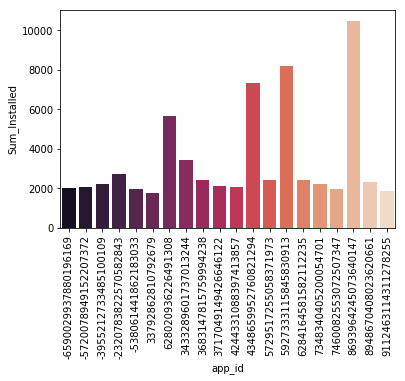

In [9]:
app_events_installed_barplot = sns.barplot(x=app_events_installed[0:20].index, 
                                           y=app_events_installed.Sum_Installed[0:20], 
                                           data=app_events_installed, palette="rocket")

app_events_installed_barplot.set_xticklabels(app_events_installed_barplot.get_xticklabels(), rotation=90)
plt.show()

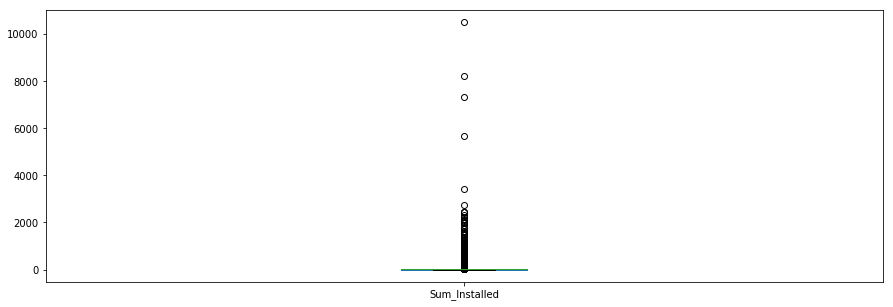

In [10]:
# Box plots
app_events_installed.plot(kind='box', subplots=False, figsize=(15,5))
plt.plot()
plt.show()

In [11]:
app_events_installed.describe()

,Sum_Installed
count,8008.000000
mean,37.462537
std,233.406550
min,1.000000
25%,1.000000
50%,3.000000
75%,11.000000
max,10484.000000


From the barchart and box plot from above we can see that the maximum an app was installed reached 10,000. However, the latter is an exceptional case, and the mean number of installations was of 37 per app.

### Most active apps

In [12]:
app_events_active = (app_events
                     .groupby('app_id')
                     .is_active.agg({'Is_Active': np.sum}))

/home/mache/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  app.launch_new_instance()


In [13]:
app_events_active.sort_values(by='Is_Active', ascending=False, inplace=True)

In [14]:
app_events_active.head()

,Is_Active
app_id,
8693964245073640147,8350
5927333115845830913,5614
4348659952760821294,3842
3433289601737013244,3412
628020936226491308,3155


/home/mache/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


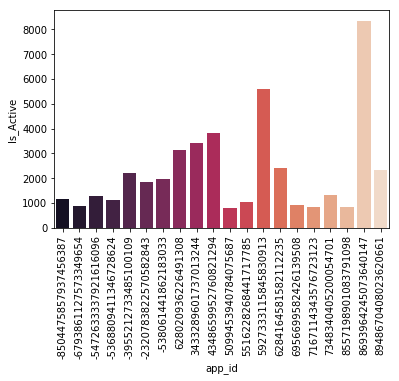

In [15]:
app_events_active_barplot = sns.barplot(x=app_events_active[0:20].index, 
                                        y=app_events_active.Is_Active[0:20], 
                                        data=app_events_active, 
                                        palette="rocket")

app_events_active_barplot.set_xticklabels(app_events_active_barplot.get_xticklabels(), rotation=90)
plt.show()

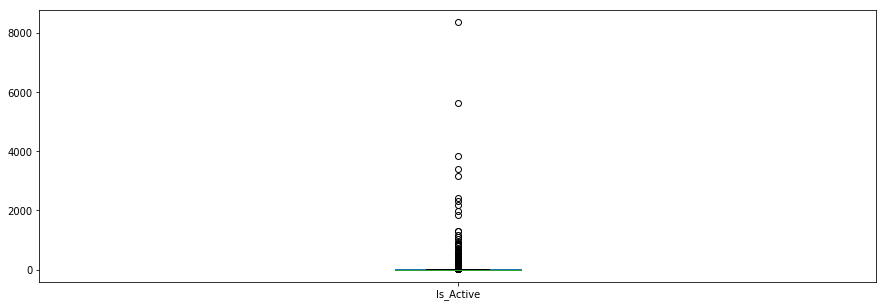

In [16]:
app_events_active.plot(kind='box', subplots=False, figsize=(15,5))
plt.plot()
plt.show()

In [17]:
app_events_active.describe()

,Is_Active
count,8008.000000
mean,14.440559
std,151.782864
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,8350.000000


From the bar chart and description information, we can also see a similar situation, were a low number of apps is highly active, but the mean activity is low.

### Exploring gender and age

In [18]:
gender_age_train.head()

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


In [19]:
gender_age_train.age.describe()

count    800.000000
mean      31.222500
std        8.647339
min       17.000000
25%       25.000000
50%       29.000000
75%       35.000000
max       78.000000
Name: age, dtype: float64

In [20]:
gender_age_train.shape

(800, 4)

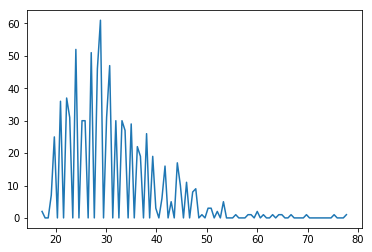

In [21]:
y,binEdges=np.histogram(gender_age_train.age,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-')
plt.show()

From the latter histogram, you can see that the age is more skewed to the left, with a mean age of 31 years.

#### Gender distribution

M    540
F    260
Name: gender, dtype: int64


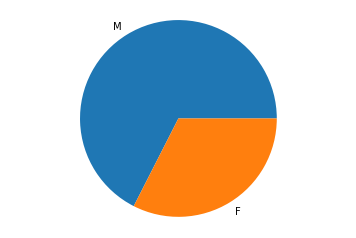

In [22]:
counts = gender_age_train.gender.value_counts()
print(counts);

plt.pie(counts.values, labels=counts.keys())
plt.axis('equal')
plt.show()

In [23]:
print(gender_age_train.gender.describe())

count     800
unique      2
top         M
freq      540
Name: gender, dtype: object


From the pie chart above we can see that the population of male users is greater than that of female user, almost 33 %.

#### Age distribution

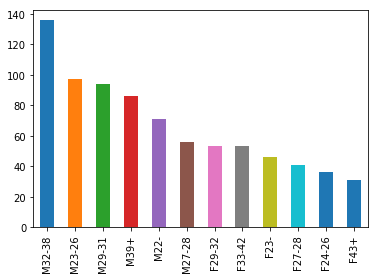

In [24]:
gender_age_train.group.value_counts().plot(kind='bar')

We can see from the bar chart above that the prdominant gender/age group is male from 23 to 26 years.

### Exploring categories dataset

We are adding a dataset that contains the categories comprehended on the iTunes catalogue, and will be matched to the exitsting categories dataset.

In [25]:
label_categories_mapping = pd.read_csv('label_categories_mapping.csv')
display(label_categories_mapping.head())

,label_itunes_id,label_itunes_category
0,1,Books
1,2,Business
2,3,Catalogs
3,4,Education
4,5,Entertainment


<a id='section4'></a>

### Combining App/Categories Data

In [26]:
app_labels.head()

,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


In [27]:
app_label_categories = pd.merge(app_labels, label_categories, left_on='label_id', right_on='label_id')

In [28]:
app_label_categories.set_index('label_id', inplace=True)

In [29]:
app_label_categories.head()

,app_id,category,label_itunes_id
label_id,,,
251,7324884708820027918,Finance,6
251,-4494216993218550286,Finance,6
251,8756705988821000489,Finance,6
251,1061207043315821111,Finance,6
251,-1491198667294647703,Finance,6


In [30]:
label_categories_mapping = pd.read_csv('label_categories_mapping.csv')
label_categories_mapping.head()

,label_itunes_id,label_itunes_category
0,1,Books
1,2,Business
2,3,Catalogs
3,4,Education
4,5,Entertainment


In [31]:
label_categories.head()

,label_id,category,label_itunes_id
0,1,NaN,26
1,2,game-game type,8
2,3,game-Game themes,8
3,4,game-Art Style,8
4,5,game-Leisure time,8


In [32]:
label_categories = pd.merge(label_categories, label_categories_mapping, left_on='label_itunes_id', right_on='label_itunes_id')

In [33]:
label_categories.head()

,label_id,category,label_itunes_id,label_itunes_category
0,1,NaN,26,Unknown
1,74,unknown,26,Unknown
2,115,unknown,26,Unknown
3,125,unknown,26,Unknown
4,126,unknown,26,Unknown


In [34]:
label_categories.set_index('label_itunes_id', inplace=True)

In [35]:
label_categories.head()

,label_id,category,label_itunes_category
label_itunes_id,,,
26,1,NaN,Unknown
26,74,unknown,Unknown
26,115,unknown,Unknown
26,125,unknown,Unknown
26,126,unknown,Unknown


In [36]:
label_categories.groupby('category').count().agg(['count', 'mean', 'min', 'max', 'sum'])

,label_id,label_itunes_category
count,833.000000,833.000000
mean,1.110444,1.110444
min,1.000000,1.000000
max,26.000000,26.000000
sum,925.000000,925.000000


In [37]:
app_labels = pd.merge(app_labels, label_categories, left_on='label_id', right_on='label_id')
app_labels.set_index('label_id', inplace=True)

In [38]:
app_labels.head()

,app_id,category,label_itunes_category
label_id,,,
251,7324884708820027918,Finance,Finance
251,-4494216993218550286,Finance,Finance
251,8756705988821000489,Finance,Finance
251,1061207043315821111,Finance,Finance
251,-1491198667294647703,Finance,Finance


In [39]:
app_cat_itunes_freq = app_labels.groupby("label_itunes_category").agg('count')

In [40]:
app_cat_itunes_freq.sort_values(by='category', ascending=False, inplace=True)

In [41]:
app_cat_itunes_freq.head()

,app_id,category
label_itunes_category,,
Unknown,37188,37188
Finance,4103,4103
Business,3409,3409
Shopping,224,224
Reference,70,70


In [42]:
app_labels_pandas = app_labels
app_labels_pandas = app_labels_pandas.sample(1000, replace=True)

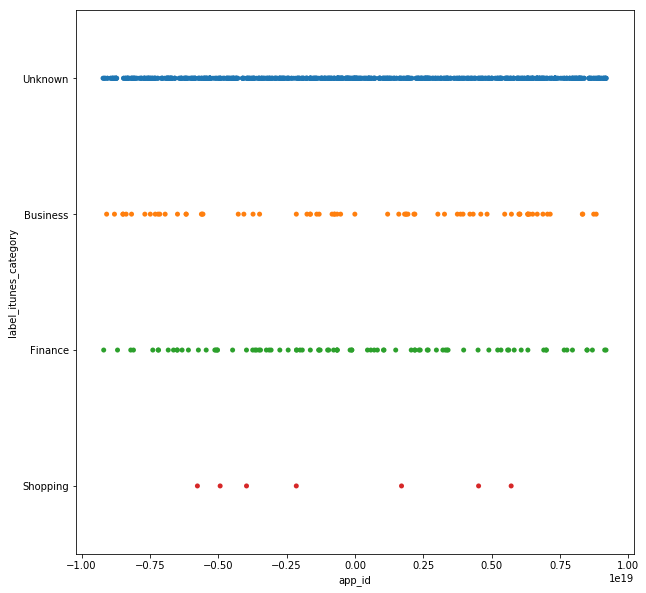

In [43]:
dimensions = (10, 10)
fig, ax = pyplot.subplots(figsize=dimensions)
sns.stripplot(x="app_id", y="label_itunes_category", data=app_labels_pandas);

We can see that a high number of apps is categorized as Unknown, and followed by a frequent use of Finance and Business apps.

### Data Transformation

In [44]:
combined_data_df = pd.merge(phone_brand_device_model, gender_age_train, left_on='device_id', right_on='device_id')

In [45]:
combined_data_df = pd.merge(combined_data_df, events, left_on='device_id', right_on='device_id')

In [46]:
combined_data_df = pd.merge(combined_data_df, app_events, left_on='event_id', right_on='event_id')

In [47]:
combined_data_df = pd.merge(combined_data_df, app_labels, left_on='app_id', right_on='app_id')

In [48]:
combined_data_df = pd.merge(combined_data_df, label_categories, left_on='label_itunes_category', right_on='label_itunes_category')

In [49]:
combined_data_df.head(1)

,device_id,phone_brand,device_model,gender,age,group,event_id,timestamp,longitude,latitude,app_id,is_installed,is_active,category_x,label_itunes_category,label_id,category_y
0,-3352337094847398864,OPPO,R7,M,21,M22-,22635,2016-05-06 19:27:52,0.0,0.0,1883678791934985414,1,1,Services 1,Unknown,1,NaN


In [50]:
combined_data_df.shape

(165063, 17)

M    134589
F     30474
Name: gender, dtype: int64


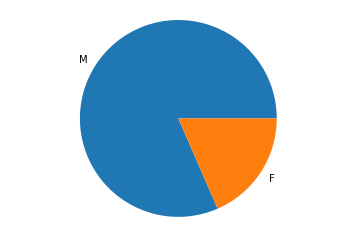

In [51]:
counts = combined_data_df.gender.value_counts()
print(counts);

plt.pie(counts.values, labels=counts.keys())
plt.axis('equal')
plt.show()

We will drop a fraction of male users to balance our data

In [52]:
combined_data_df = combined_data_df.drop(combined_data_df[combined_data_df['gender'] == 'M'].sample(frac=0.77).index)

In [53]:
combined_data_df.shape

(61429, 17)

In [54]:
combined_data_df.gender.value_counts()

M    30955
F    30474
Name: gender, dtype: int64

M    30955
F    30474
Name: gender, dtype: int64


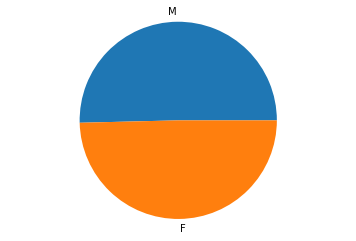

In [55]:
counts = combined_data_df.gender.value_counts()
print(counts);

plt.pie(counts.values, labels=counts.keys())
plt.axis('equal')
plt.show()

In [56]:
dummy = pd.get_dummies(combined_data_df)

In [57]:
dummy.shape

(61429, 614)

In [58]:
features = dummy.drop(['gender_F', 'gender_M', 'age'], axis=1).columns
X = dummy[features]
Y = dummy['gender_F']
X2 = X
Y2 = Y
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [59]:
print("Normal data distribution: {}".format(Counter(Y_train)))

normal data distribution: Counter({0: 24765, 1: 24378})


0    24765
1    24378
Name: gender_F, dtype: int64


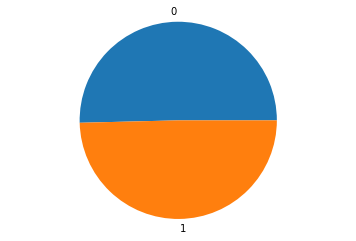

In [60]:
counts = Y_train.value_counts()
print(counts);

plt.pie(counts.values, labels=counts.keys())
plt.axis('equal')
plt.show()

In [61]:
dummy.gender_F.value_counts()

0    30955
1    30474
Name: gender_F, dtype: int64

In [62]:
#sm = SMOTE(random_state=12, ratio=1.0)
#X_train, Y_train = sm.fit_sample(X_train, Y_train)

In [63]:
#print("SMOTE data distribution: {}".format(Counter(Y_train)))

In [64]:
# We create several dataframes for each model

X_train_LR = X_train
X_validation_LR = X_validation
Y_train_LR = Y_train
Y_validation_LR = Y_validation

X_train_RF = X_train
X_validation_RF = X_validation
Y_train_RF = Y_train
Y_validation_RF = Y_validation

X_train_DT = X_train
X_validation_DT = X_validation
Y_train_DT = Y_train
Y_validation_DT = Y_validation

X_train_KNN = X_train
X_validation_KNN = X_validation
Y_train_KNN = Y_train
Y_validation_KNN = Y_validation

X_train_RI = X_train
X_validation_RI = X_validation
Y_train_RI = Y_train
Y_validation_RI = Y_validation

<a id='section5'></a>
### Training, testing and evaluation

<a id='section6'></a>
#### Training and testing with GridSearchCV

#### Logistic Regression (Classification L2)

In [65]:
log_reg_model = linear_model.LogisticRegression(penalty = 'l2')

In [66]:
# Define the parameter values that should be searched# Define 
C = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

In [67]:
# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(C)
print(param_grid)

{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


In [68]:
# instantiate and fit the grid
grid = GridSearchCV(log_reg_model, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train_LR, Y_train_LR)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [69]:
# Logistic Regression
start = time.time()
grid.fit(X_train_LR, Y_train_LR)
log_reg_pred = grid.predict(X_train_LR)
print ("Runtime %0.2f" % (time.time() - start))

Runtime 61.32


In [70]:
# View the complete results
grid.grid_scores_

/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.58682, std: 0.00861, params: {'C': 0.001},
 mean: 0.58682, std: 0.00861, params: {'C': 0.01},
 mean: 0.58682, std: 0.00861, params: {'C': 0.1},
 mean: 0.58682, std: 0.00861, params: {'C': 1},
 mean: 0.58682, std: 0.00861, params: {'C': 10},
 mean: 0.58682, std: 0.00861, params: {'C': 100},
 mean: 0.58682, std: 0.00861, params: {'C': 1000}]

In [71]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.586818061575
{'C': 0.001}


In [72]:
log_reg_model.fit(X_train_LR, Y_train_LR)
log_reg_pred = log_reg_model.predict(X_train_LR)

             precision    recall  f1-score   support

   gender_F       0.57      0.73      0.64     24765
   gender_M       0.62      0.44      0.52     24378

avg / total       0.59      0.59      0.58     49143



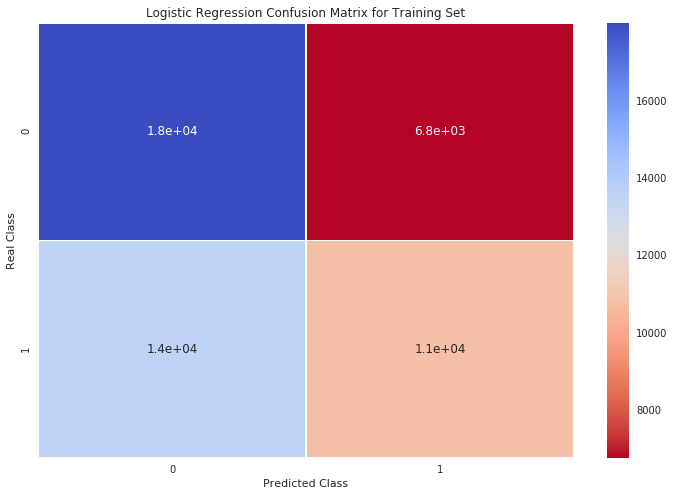

Cross Validation Accuracy Scores: 0.587(+/- 0.02)
Cross Validation Accuracy Scores - Test Set: 0.589(+/- 0.02)


In [73]:
# Printing classification report
print(classification_report(Y_train_LR, log_reg_pred, target_names=['gender_F', 'gender_M']))

# Building confusion matrix
conf_matrix_train_logR = confusion_matrix(Y_train_LR, log_reg_pred)

#creating heatmap of confusion matrix
plt.figure(figsize = (12,8))
sns.set(rc={'axes.grid': False, 'axes.linewidth': 1 }, font_scale=1)
sns.heatmap(conf_matrix_train_logR,
           cmap='coolwarm_r',
           annot=True,
           linewidths=0.5)
plt.title('Logistic Regression Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_logR = cross_val_score(log_reg_model, X_train_LR, Y_train_LR, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_logR.mean(), scores_logR.std()*2))

scores_logRTest = cross_val_score(log_reg_model, X_validation_LR, Y_validation_LR, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_logRTest.mean(), scores_logRTest.std()*2))

#### Random Forest

In [74]:
rfc = ensemble.RandomForestClassifier()

In [75]:
# Define the parameter values that should be searched
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 4, num = 1)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [76]:
# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [1], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [77]:
# Random Forest Classifier: instantiate and fit the grid# Random 
start = time.time()
grid = GridSearchCV(rfc, param_grid, verbose=1, cv=4, scoring='accuracy')
grid.fit(X_train_RF, Y_train_RF)
Y_pred_rfc = grid.predict(X_train_RF)
print ("Runtime %0.2f" % (time.time() - start))

Fitting 4 folds for each of 432 candidates, totalling 1728 fits


[Parallel(n_jobs=1)]: Done 1728 out of 1728 | elapsed: 12.8min finished


Runtime 770.58


In [78]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.999959302444
{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1}


In [79]:
rfc = ensemble.RandomForestClassifier(bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=10, n_estimators=1)
rfc.fit(X_train_RF, Y_train_RF)
Y_pred_rfc = rfc.predict(X_train_RF)

             precision    recall  f1-score   support

   gender_F       1.00      1.00      1.00     24765
   gender_M       1.00      1.00      1.00     24378

avg / total       1.00      1.00      1.00     49143



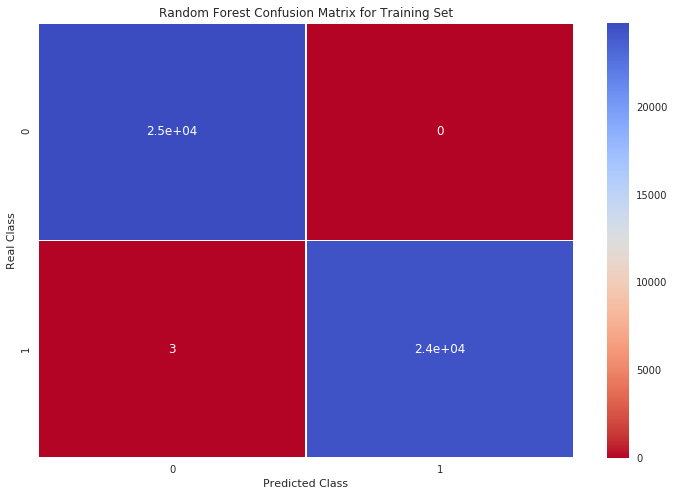

Cross Validation Accuracy Scores: 1.000(+/- 0.00)
Cross Validation Accuracy Scores - Test Set: 1.000(+/- 0.00)


In [80]:
# Print classification report
print(classification_report(Y_train_RF, Y_pred_rfc, target_names=['gender_F', 'gender_M']))

# Building confusion matrix
conf_matrix_rfc = confusion_matrix(Y_train_RF, Y_pred_rfc)

# Creating heatmap of confusion matrix
plt.figure(figsize = (12,8))
sns.set(rc={'axes.grid': False, 'axes.linewidth': 1 }, font_scale=1)
sns.heatmap(conf_matrix_rfc, 
            cmap='coolwarm_r', 
            annot=True, 
            linewidths=0.5)
plt.title('Random Forest Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_rfc = cross_val_score(rfc, X_train_RF, Y_train_RF, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_rfc.mean(), scores_rfc.std()*2))

scores_rfcTest = cross_val_score(rfc, X_validation_RF, Y_validation_RF, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_rfcTest.mean(), scores_rfcTest.std()*2))

#### Decision Tree

In [81]:
clf = DecisionTreeClassifier()

In [82]:
# Define the parameter values that should be searched
param_grid = {'min_samples_split' : range(10,500,20),'max_depth': range(1,20,2),'criterion' : ['gini', 'entropy']}

In [83]:
# instantiate and fit the grid
start = time.time()
grid = GridSearchCV(clf, param_grid, verbose=1, cv=4, scoring='accuracy')
grid.fit(X_train_DT, Y_train_DT)
Y_pred_clf = grid.predict(X_train_DT)
print ("Runtime %0.2f" % (time.time() - start))

Fitting 4 folds for each of 500 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed: 23.6min finished


Runtime 1417.85


In [84]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)

1.0
{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10}


In [85]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=13, min_samples_split=10)
clf.fit(X_train_DT, Y_train_DT)
Y_pred_clf = clf.predict(X_train_DT)

             precision    recall  f1-score   support

   gender_F       1.00      1.00      1.00     24765
   gender_M       1.00      1.00      1.00     24378

avg / total       1.00      1.00      1.00     49143



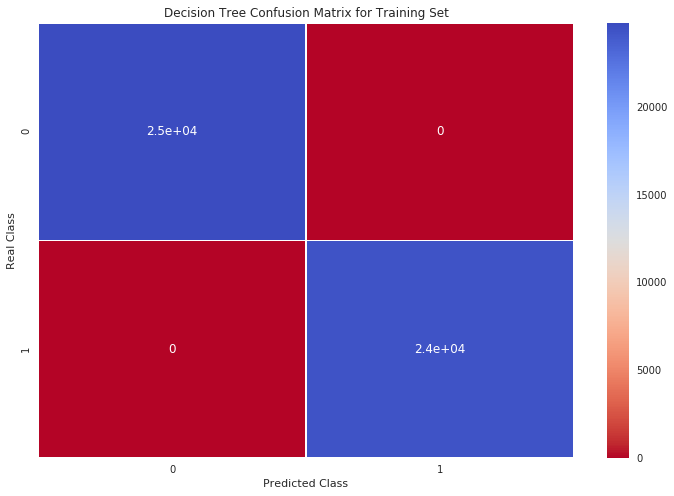

Cross Validation Accuracy Scores: 1.000(+/- 0.00)
Cross Validation Accuracy Scores - Test Set: 1.000(+/- 0.00)


In [86]:
# Print classification report
print(classification_report(Y_train_DT, Y_pred_clf, target_names=['gender_F', 'gender_M']))

# Building confusion matrix
conf_matrix_clf = confusion_matrix(Y_train_DT, Y_pred_clf)

# Creating heatmap of confusion matrix
plt.figure(figsize = (12,8))
#sns.set(rc={'axes.facecolor':'#757575ff', 'figure.facecolor':'#757575ff', 'axes.grid': False, 'axes.linewidth': 1 }, font_scale=1.5)
sns.set(rc={'axes.grid': False, 'axes.linewidth': 1 }, font_scale=1)
sns.heatmap(conf_matrix_clf, 
            cmap='coolwarm_r', 
            annot=True, 
            linewidths=0.5)
plt.title('Decision Tree Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_clf = cross_val_score(clf, X_train_DT, Y_train_DT, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_clf.mean(), scores_clf.std()*2))

scores_clfTest = cross_val_score(clf, X_validation_DT, Y_validation_DT, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_clfTest.mean(), scores_clfTest.std()*2))

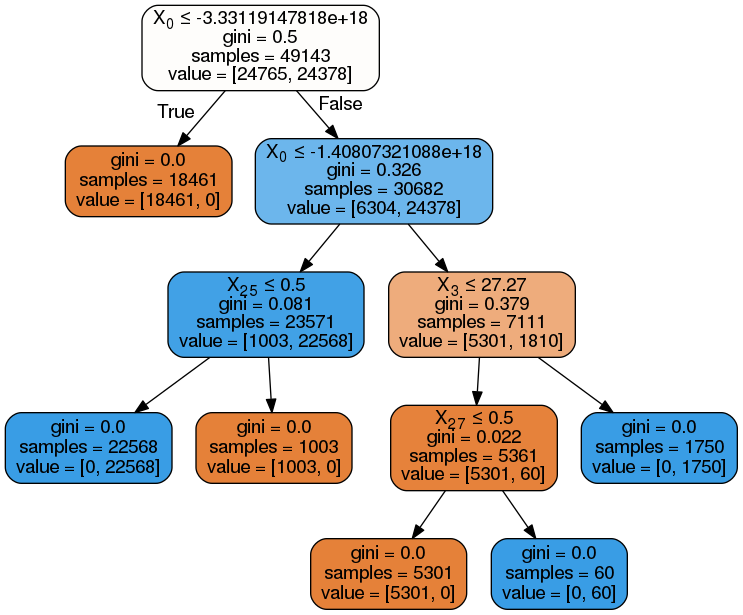

In [87]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

#### KNN

In [88]:
knn_model = KNeighborsClassifier()

In [89]:
# Define the parameter values that should be searched
k_range = list(range(1, 10))
param_grid = dict(n_neighbors=k_range)

In [90]:
# KNN Classifier
start = time.time()
grid = GridSearchCV(knn_model, param_grid, verbose=1, cv=4, scoring='accuracy')
grid.fit(X_train_KNN, Y_train_KNN)
Y_pred_knn = grid.predict(X_train_KNN)
print ("Runtime %0.2f" % (time.time() - start))

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 28.4min finished


Runtime 1743.24


In [91]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)

1.0
{'n_neighbors': 1}


In [92]:
knn_model = KNeighborsClassifier(n_neighbors=9)
knn_model.fit(X_train_KNN, Y_train_KNN)
Y_pred_knn = knn_model.predict(X_train_KNN)

             precision    recall  f1-score   support

   gender_F       1.00      1.00      1.00     24765
   gender_M       1.00      1.00      1.00     24378

avg / total       1.00      1.00      1.00     49143



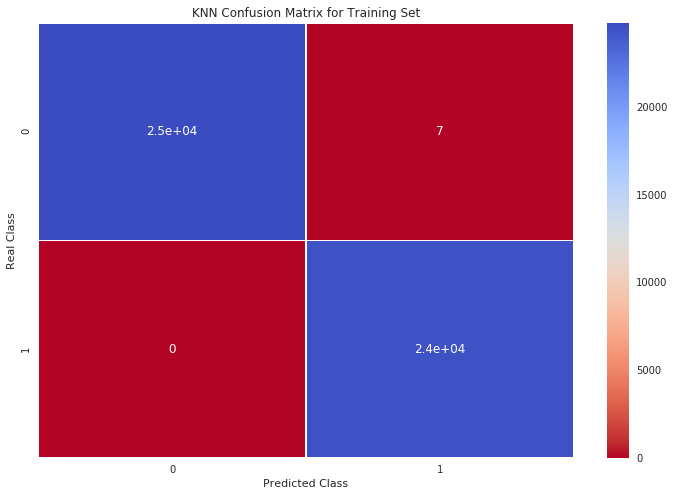

Cross Validation Accuracy Scores: 1.000(+/- 0.00)
Cross Validation Accuracy Scores - Test Set: 0.998(+/- 0.00)


In [93]:
# Print classification report
print(classification_report(Y_train_KNN, Y_pred_knn, target_names=['gender_F', 'gender_M']))

# Building confusion matrix
conf_matrix_knn = confusion_matrix(Y_train_KNN, Y_pred_knn)

# Creating heatmap of confusion matrix
plt.figure(figsize = (12,8))
sns.set(rc={'axes.grid': False, 'axes.linewidth': 1 }, font_scale=1)
sns.heatmap(conf_matrix_knn, 
            cmap='coolwarm_r', 
            annot=True, 
            linewidths=0.5)
plt.title('KNN Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_knn = cross_val_score(knn_model, X_train_KNN, Y_train_KNN, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_knn.mean(), scores_knn.std()*2))

scores_knnTest = cross_val_score(knn_model, X_validation_KNN, Y_validation_KNN, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_knnTest.mean(), scores_knnTest.std()*2))

#### Ridge

In [94]:
rclass = RidgeClassifier()

In [95]:
# Define the parameter values that should be searched# Define 
param_grid = {'alpha': [25,10,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01]}

In [96]:
# Ridge Classifier
start = time.time()
grid = GridSearchCV(rclass, param_grid, verbose=1, cv=4, scoring='accuracy')
grid.fit(X_train_RI, Y_train_RI)
Y_pred_rclass = grid.predict(X_train_RI)
print ("Runtime %0.2f" % (time.time() - start))

Fitting 4 folds for each of 13 candidates, totalling 52 fits


[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:  1.2min finished


Runtime 71.15


In [97]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)

1.0
{'alpha': 25}


In [98]:
rclass = RidgeClassifier(alpha=0.8)
rclass.fit(X_train_RI, Y_train_RI)
Y_pred_rclass = rclass.predict(X_train_RI)

             precision    recall  f1-score   support

   gender_F       1.00      1.00      1.00     24765
   gender_M       1.00      1.00      1.00     24378

avg / total       1.00      1.00      1.00     49143



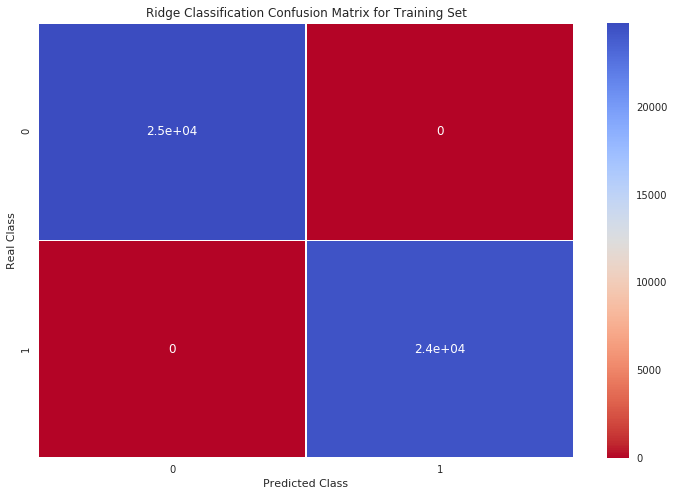

Cross Validation Accuracy Scores: 1.000(+/- 0.00)
Cross Validation Accuracy Scores - Test Set: 1.000(+/- 0.00)


In [99]:
# Print classification report
print(classification_report(Y_train_RI, Y_pred_rclass, target_names=['gender_F', 'gender_M']))

# Building confusion matrix
conf_matrix_rclass = confusion_matrix(Y_train_RI, Y_pred_rclass)

# Creating heatmap of confusion matrix
plt.figure(figsize = (12,8))
sns.set(rc={'axes.grid': False, 'axes.linewidth': 1 }, font_scale=1)
sns.heatmap(conf_matrix_rclass, 
            cmap='coolwarm_r', 
            annot=True, 
            linewidths=0.5)
plt.title('Ridge Classification Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_rclass = cross_val_score(rclass, X_train_RI, Y_train_RI, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_rclass.mean(), scores_rclass.std()*2))

scores_rclassTest = cross_val_score(rclass, X_validation_RI, Y_validation_RI, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_rclassTest.mean(), scores_rclassTest.std()*2))

<a id='section7'></a>
### Training and testing applying PCA

In [100]:
# Standardize the feature matrix
X = StandardScaler().fit_transform(X_train)

In [101]:
# Create a PCA that will retain 90% of the variance
pca = PCA(n_components=0.75, whiten=True)

# Conduct PCA
X_pca = pca.fit_transform(X)

In [102]:
# Show results
print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_pca.shape[1])

Original number of features: 611
Reduced number of features: 398


In [103]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = Y_train)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

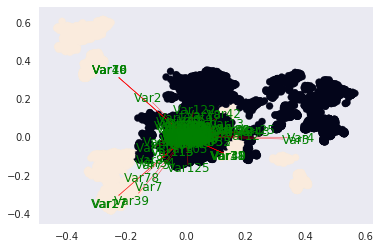

In [104]:
#Call the function. Use only the 2 PCs.
myplot(X_pca[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

#### Logistic Regression (L2)

In [105]:
pipe = Pipeline([('pca', pca), ('logistic', log_reg_model)])
pipe.fit(X_train, Y_train)
pred = pipe.predict(X_train)

In [106]:
# Printing classification report
print(classification_report(Y_train, pred, target_names=['gender_F', 'gender_M']))

scores = cross_val_score(pipe, X_train, Y_train, cv=4)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

scores_T = cross_val_score(pipe, X_validation, Y_validation, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_T.mean(), scores_T.std()*2))

             precision    recall  f1-score   support

   gender_F       0.65      0.70      0.67     24765
   gender_M       0.67      0.62      0.64     24378

avg / total       0.66      0.66      0.66     49143

Cross Validation Accuracy Scores: 0.655(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.644(+/- 0.03)


#### Random Forest Classification

In [107]:
pipe = Pipeline([('pca', pca), ('rfc', rfc)])
pipe.fit(X_train, Y_train)
pred = pipe.predict(X_train)

In [108]:
# Printing classification report
print(classification_report(Y_train, pred, target_names=['gender_F', 'gender_M']))

scores = cross_val_score(pipe, X_train, Y_train, cv=4)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

scores_T = cross_val_score(pipe, X_validation, Y_validation, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_T.mean(), scores_T.std()*2))

             precision    recall  f1-score   support

   gender_F       1.00      1.00      1.00     24765
   gender_M       1.00      1.00      1.00     24378

avg / total       1.00      1.00      1.00     49143

Cross Validation Accuracy Scores: 1.000(+/- 0.00)
Cross Validation Accuracy Scores - Test Set: 1.000(+/- 0.00)


#### Decision Tree Classification

In [109]:
pipe = Pipeline([('pca', pca), ('clf', clf)])
pipe.fit(X_train, Y_train)
pred = pipe.predict(X_train)

In [110]:
# Printing classification report
print(classification_report(Y_train, pred, target_names=['gender_F', 'gender_M']))

scores = cross_val_score(pipe, X_train, Y_train, cv=4)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

scores_T = cross_val_score(pipe, X_validation, Y_validation, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_T.mean(), scores_T.std()*2))

             precision    recall  f1-score   support

   gender_F       1.00      0.99      1.00     24765
   gender_M       0.99      1.00      1.00     24378

avg / total       1.00      1.00      1.00     49143

Cross Validation Accuracy Scores: 0.996(+/- 0.00)
Cross Validation Accuracy Scores - Test Set: 1.000(+/- 0.00)


#### KNN

In [111]:
pipe = Pipeline([('pca', pca), ('knn', knn_model)])
pipe.fit(X_train, Y_train)
pred = pipe.predict(X_train)

In [112]:
# Printing classification report
print(classification_report(Y_train, pred, target_names=['gender_F', 'gender_M']))

scores = cross_val_score(pipe, X_train, Y_train, cv=4)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

scores_T = cross_val_score(pipe, X_validation, Y_validation, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_T.mean(), scores_T.std()*2))

             precision    recall  f1-score   support

   gender_F       1.00      1.00      1.00     24765
   gender_M       1.00      1.00      1.00     24378

avg / total       1.00      1.00      1.00     49143

Cross Validation Accuracy Scores: 0.999(+/- 0.00)
Cross Validation Accuracy Scores - Test Set: 0.998(+/- 0.00)


#### Ridge

In [113]:
pipe = Pipeline([('pca', pca), ('rclass', rclass)])
pipe.fit(X_train, Y_train)
pred = pipe.predict(X_train)

In [114]:
# Printing classification report# Printin 
print(classification_report(Y_train, pred, target_names=['gender_F', 'gender_M']))

scores = cross_val_score(pipe, X_train, Y_train, cv=4)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

scores_T = cross_val_score(pipe, X_validation, Y_validation, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_T.mean(), scores_T.std()*2))

             precision    recall  f1-score   support

   gender_F       0.64      0.69      0.66     24765
   gender_M       0.66      0.60      0.63     24378

avg / total       0.65      0.65      0.65     49143

Cross Validation Accuracy Scores: 0.646(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.640(+/- 0.02)


In [115]:
X_validation.shape, Y_validation.shape


((12286, 611), (12286,))

In [116]:
print("# Num of Features: ", X_train.shape[1])

# Num of Features:  611


In [117]:
print(X_train.shape)
print(X_validation.shape)
print(Y_train.shape)
print(Y_validation.shape)

(49143, 611)
(12286, 611)
(49143,)
(12286,)


<a id='section8'></a>
### Training and testing applying PCA and KMeans Clustering

In [118]:
X2 = pd.DataFrame(X2)
print('X2 original shape:', X2.shape)
pca = PCA(n_components=300, whiten=True)

# Conduct PCA
X2_pca = pca.fit_transform(X2)
print('X2_PCA shape:', X2_pca.shape)

#Holdout
X2_train, X2_validation, Y2_train, Y2_validation = model_selection.train_test_split(X2_pca, Y2, test_size=0.2, random_state=7)

# Dataset Balancing
sm = SMOTE(random_state=12, ratio=1.0)
X2_train, Y2_train = sm.fit_sample(X2_train, Y2_train)

# KMeans model & fitting
km = KMeans(n_clusters=4)
km.fit(X2_train)

# Converting sets to Pandas dataframe
X2_train = pd.DataFrame(X2_train)
X2_validation = pd.DataFrame(X2_validation)

X2 original shape: (61429, 611)
X2_PCA shape: (61429, 300)


/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


#### Logistic Regression (L2)

In [119]:
# Fitting Logistic Regression model
pipe = Pipeline([('logistic', log_reg_model)])
pipe.fit(X2_train, Y2_train)
pred = pipe.predict(X2_train)

# Printing classification report
print(classification_report(Y2_train, pred, target_names=['gender_F', 'gender_M']))

scores = cross_val_score(pipe, X2_train, Y2_train, cv=4)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

scores_T = cross_val_score(pipe, X2_validation, Y2_validation, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_T.mean(), scores_T.std()*2))

             precision    recall  f1-score   support

   gender_F       1.00      1.00      1.00     24765
   gender_M       1.00      1.00      1.00     24765

avg / total       1.00      1.00      1.00     49530

Cross Validation Accuracy Scores: 1.000(+/- 0.00)
Cross Validation Accuracy Scores - Test Set: 1.000(+/- 0.00)


#### Random Forest

In [120]:
# Fitting Random Forest model
pipe = Pipeline([('rfc', rfc)])
pipe.fit(X2_train, Y2_train)
pred = pipe.predict(X2_train)

# Printing classification report
print(classification_report(Y2_train, pred, target_names=['gender_F', 'gender_M']))

scores = cross_val_score(pipe, X2_train, Y2_train, cv=4)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

scores_T = cross_val_score(pipe, X2_validation, Y2_validation, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_T.mean(), scores_T.std()*2))

             precision    recall  f1-score   support

   gender_F       1.00      1.00      1.00     24765
   gender_M       1.00      1.00      1.00     24765

avg / total       1.00      1.00      1.00     49530

Cross Validation Accuracy Scores: 0.989(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.965(+/- 0.03)


#### Decision Tree

In [121]:
# Fitting Decision Tree model
pipe = Pipeline([('clf', clf)])
pipe.fit(X2_train, Y2_train)
pred = pipe.predict(X2_train)

# Printing classification report
print(classification_report(Y2_train, pred, target_names=['gender_F', 'gender_M']))

scores = cross_val_score(pipe, X2_train, Y2_train, cv=4)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

scores_T = cross_val_score(pipe, X2_validation, Y2_validation, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_T.mean(), scores_T.std()*2))

             precision    recall  f1-score   support

   gender_F       1.00      1.00      1.00     24765
   gender_M       1.00      1.00      1.00     24765

avg / total       1.00      1.00      1.00     49530

Cross Validation Accuracy Scores: 0.998(+/- 0.00)
Cross Validation Accuracy Scores - Test Set: 0.999(+/- 0.00)


#### KNN

In [122]:
# Fitting KNN model
pipe = Pipeline([('knn', knn_model)])
pipe.fit(X2_train, Y2_train)
pred = pipe.predict(X2_train)

# Printing classification report
print(classification_report(Y2_train, pred, target_names=['gender_F', 'gender_M']))

scores = cross_val_score(pipe, X2_train, Y2_train, cv=4)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

scores_T = cross_val_score(pipe, X2_validation, Y2_validation, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_T.mean(), scores_T.std()*2))

             precision    recall  f1-score   support

   gender_F       0.99      0.76      0.86     24765
   gender_M       0.81      0.99      0.89     24765

avg / total       0.90      0.88      0.87     49530

Cross Validation Accuracy Scores: 0.808(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.697(+/- 0.02)


#### Ridge

In [123]:
# Fitting Ridge model
pipe = Pipeline([('rclass', rclass)])
pipe.fit(X2_train, Y2_train)
pred = pipe.predict(X2_train)

# Printing classification report
print(classification_report(Y2_train, pred, target_names=['gender_F', 'gender_M']))

scores = cross_val_score(pipe, X2_train, Y2_train, cv=4)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

scores_T = cross_val_score(pipe, X2_validation, Y2_validation, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_T.mean(), scores_T.std()*2))

             precision    recall  f1-score   support

   gender_F       1.00      1.00      1.00     24765
   gender_M       1.00      1.00      1.00     24765

avg / total       1.00      1.00      1.00     49530

Cross Validation Accuracy Scores: 1.000(+/- 0.00)
Cross Validation Accuracy Scores - Test Set: 1.000(+/- 0.00)


<a id='section9'></a>
### Running Neural Networks models

#### Creating independent datasets

In [124]:
X_train_NN = X_train
X_validation_NN = X_validation
Y_train_NN = Y_train
Y_validation_NN = Y_validation

In [125]:
X_train_NN_2 = X_train
X_validation_NN_2 = X_validation
Y_train_NN_2 = Y_train
Y_validation_NN_2 = Y_validation

#### Importing necessary libraries

In [126]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Activation, BatchNormalization
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop, SGD
from keras.layers.advanced_activations import PReLU
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import VotingClassifier
from keras import optimizers

# Import the backend
from keras import backend as K

Using TensorFlow backend.


#### Defining model

In [127]:
def mlp_model():
    model = Sequential()
    
    model.add(Dense(50, input_shape = (611, ), kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, kernel_initializer='he_normal'))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
    model.summary()
    
    return model

#### Creating 5 different models to ensemble

In [128]:
model1 = KerasClassifier(build_fn = mlp_model, epochs = 3)
model2 = KerasClassifier(build_fn = mlp_model, epochs = 5)
model3 = KerasClassifier(build_fn = mlp_model, epochs = 7)
model4 = KerasClassifier(build_fn = mlp_model, epochs = 8)
model5 = KerasClassifier(build_fn = mlp_model, epochs = 9)

#### Evaluating performance based on one only model

In [129]:
model_1_a = model1.fit(X_train_NN_2, Y_train_NN_2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                30600     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_________________________________________________________________
activation_2 (Activation)    (None, 50)                0         
__________

In [130]:
y_pred_model_1 = model1.predict(X_validation_NN_2)

In [131]:
print('Acc: ', accuracy_score(y_pred_model_1, Y_validation_NN_2))

Acc:  0.943024580824


#### Evaluating performance based on ensambled models

In [132]:
ensemble_clf = VotingClassifier(estimators = [('model1', model1), ('model2', model2), ('model3', model3), ('model4', model4), ('model5', model5)], voting = 'soft')

In [133]:
%%time
ensemble_clf.fit(X_train_NN, Y_train_NN)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 50)                30600     
_________________________________________________________________
batch_normalization_5 (Batch (None, 50)                200       
_________________________________________________________________
activation_6 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_6 (Batch (None, 50)                200       
_________________________________________________________________
activation_7 (Activation)    (None, 50)                0         
__________

Epoch 1/7
49143/49143 [==============================] - 15s 314us/step - loss: 0.3565 - acc: 0.8463
Epoch 2/7
49143/49143 [==============================] - 9s 187us/step - loss: 0.2974 - acc: 0.8747
Epoch 3/7
49143/49143 [==============================] - 16s 329us/step - loss: 0.2729 - acc: 0.8917
Epoch 4/7
49143/49143 [==============================] - 16s 328us/step - loss: 0.2644 - acc: 0.8970
Epoch 5/7
49143/49143 [==============================] - 16s 327us/step - loss: 0.2565 - acc: 0.9027
Epoch 6/7
49143/49143 [==============================] - 19s 385us/step - loss: 0.2485 - acc: 0.9064
Epoch 7/7
49143/49143 [==============================] - 24s 491us/step - loss: 0.2416 - acc: 0.9112
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 50)                30600     
_________________________________________________________________
batch_normalization_17 (Batc (

VotingClassifier(estimators=[('model1', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f4e8aa622e8>), ('model2', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f4e8aa62748>), ('model3', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f4e8aa62630>), ('model4', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f4e8aa625c0>), ('model5', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f4e8aa62390>)],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [134]:
y_pred = ensemble_clf.predict(X_validation_NN)

In [135]:
print('Acc: ', accuracy_score(y_pred, Y_validation_NN))

Acc:  0.953524336643


### Conclusion

After analysing the datasets, we were able to determine that the the median age and gender group was 25 years old and male. We devided our model training and testing in four different types of modelling. First we used plain supervised models, we then applied PCA to these same models and tested their results. Later, we used K-Means clustering and evaluated their performance. And finally we modelled our dataset with neural networks and used a Keras classification MLP model to predict the user's gender. We can see the results in thefollowing table:

Supervised models:

- Logistic Regression - Cross Validation Accuracy Scores - Test Set: 0.589(+/- 0.02)
- Random Forest - Cross Validation Accuracy Scores - Test Set: 1.000(+/- 0.00)
- Decision Tree -Cross Validation Accuracy Scores - Test Set: 1.000(+/- 0.00)
- KNN - Cross Validation Accuracy Scores - Test Set: 0.998(+/- 0.00)
- Ridge - Cross Validation Accuracy Scores - Test Set: 1.000(+/- 0.00)

Supervised learning applying PCA

- Logistic Regression - Cross Validation Accuracy Scores - Test Set: 0.644(+/- 0.03)
- Random Forest - Cross Validation Accuracy Scores - Test Set: 1.000(+/- 0.00)
- Decision Tree - Cross Validation Accuracy Scores - Test Set: 1.000(+/- 0.00)
- KNN - Cross Validation Accuracy Scores - Test Set: 0.998(+/- 0.00)
- Ridge - Cross Validation Accuracy Scores - Test Set: 0.640(+/- 0.02)

Supervised learning applying PCA and KMeans Clustering

- Logistic Regression - Cross Validation Accuracy Scores - Test Set: 1.000(+/- 0.00)
- Random Forest - Cross Validation Accuracy Scores - Test Set: 0.965(+/- 0.03)
- Decision Tree - Cross Validation Accuracy Scores - Test Set: 0.999(+/- 0.00)
- KNN - Cross Validation Accuracy Scores - Test Set: 0.697(+/- 0.02)
- Ridge - Cross Validation Accuracy Scores - Test Set: 1.000(+/- 0.00)

Running Neural Networks models

- Single model - Acc:  0.943024580824

- Ensembled models - Acc:  0.953524336643

As we can see, the performance with several mdoels was very satisfactory, however, I would choose the neural networks model, since it's capacity to handle large datasets, and use a considerable number of dropouts, assure that overfitting is less prone to appear. Therefore, such a model would be great to determine the demographics of certain application, and thus, being able to target, for example, advertising for that given segment.